<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Natural%20Language%20Processing/Text_classification_using_Google_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

google guide : https://developers.google.com/machine-learning/guides/text-classification

this guide use the Internet Movie Database (IMDb) movie reviews dataset to illustrate the workflow. This dataset contains movie reviews posted by people on the IMDb website, as well as the corresponding labels (“positive” or “negative”) indicating whether the reviewer liked the movie or not. This is a classic example of a sentiment analysis problem.

## Text Classification Workflow
Here’s a high-level overview of the workflow used to solve machine learning problems:

* Step 1: Gather Data
* Step 2: Explore Your Data
* Step 2.5: Choose a Model*
* Step 3: Prepare Your Data
* Step 4: Build, Train, and Evaluate Your Model
* Step 5: Tune Hyperparameters
* Step 6: Deploy Your Model

<img src='https://developers.google.com/machine-learning/guides/text-classification/images/Workflow.png'/>

In [1]:
# imports
import tensorflow as tf
import tensorflow_hub as hub
import shutil
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import collections


import scipy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

## Gather Data

In [2]:
data_dir = tf.keras.utils.get_file(fname='aclImbd',
                                   origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
                                   cache_dir='.',
                                   cache_subdir='',
                                   untar=True)

84140032/84125825 [==============================] - 2s 0us/step


In [3]:
data_dir = os.path.join(os.path.dirname(data_dir),'aclImdb')
print('data directory ',data_dir)

data directory  ./aclImdb


## Explore the Data

### Create Train Test split

#### Method 1 using `text_dataset_from_directory`

`text_dataset_from_directory` utility, which expects a directory structure as follows.

<br>
main_directory/<br>
...class_a/<br>
......a_text_1.txt<br>
......a_text_2.txt<br>
...class_b/<br>
......b_text_1.txt<br>
......b_text_2.txt<br>
<br>


In [4]:
#  '.'
print('directory ',os.listdir('.'))

directory  ['.config', 'aclImdb', 'aclImbd.tar.gz', 'sample_data']


In [5]:
# './aclImbd'
print('directory ',os.listdir(data_dir))

directory  ['test', 'README', 'imdbEr.txt', 'train', 'imdb.vocab']


In [6]:
# './aclImbd\train'
train_dir = os.path.join(data_dir,'train')
# './aclImbd\test'
test_dir = os.path.join(data_dir,'test')
print('train directory ',os.listdir(train_dir))
print('test directory ',os.listdir(test_dir))

train directory  ['neg', 'urls_pos.txt', 'unsupBow.feat', 'pos', 'urls_unsup.txt', 'urls_neg.txt', 'labeledBow.feat', 'unsup']
test directory  ['neg', 'urls_pos.txt', 'pos', 'urls_neg.txt', 'labeledBow.feat']


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
print('train directory ',os.listdir(train_dir))

train directory  ['neg', 'urls_pos.txt', 'unsupBow.feat', 'pos', 'urls_unsup.txt', 'urls_neg.txt', 'labeledBow.feat']


In [8]:
# method 1  using 'tf.keras.preprocessing.text_dataset_from_directory'

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(directory=train_dir,seed=42,validation_split=0.2,subset='training')
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(directory=train_dir,seed=42,validation_split=0.2,subset='validation')
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(directory=test_dir,seed=42)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


#### Method 2 from scratch using python

In [9]:
# method 2  from scratch using python

def train_test_split(data_dir):

  train_dir = os.path.join(data_dir,'train')
  test_dir = os.path.join(data_dir,'test')

  train_data = []
  train_labels = []
  for review in ['pos', 'neg']:
    data_files = os.path.join(train_dir, review)
    for fname in sorted(os.listdir(data_files)):
      # file directory
      f_dir = os.path.join(data_files,fname)
      # read the file and append 
      with open(f_dir) as f:
        train_data.append(f.read())
      # append the corresponding label
      train_labels.append(0 if review == 'neg' else 1)

  test_data = []
  test_labels = []
  for review in ['pos', 'neg']:
    data_files = os.path.join(test_dir, review)
    for fname in sorted(os.listdir(data_files)):
      # file directory
      f_dir = os.path.join(data_files,fname)
      # read the file and append 
      with open(f_dir) as f:
        test_data.append(f.read())
      # append the corresponding label
      test_labels.append(0 if review == 'neg' else 1)

  # Shuffle the training data and labels.
  seed = 42
  random.seed(seed)
  random.shuffle(train_data)
  random.seed(seed)
  random.shuffle(train_labels)

  return ((train_data, np.array(train_labels)),(test_data, np.array(test_labels)))



# create validtion split from train split
def val_split(train_data, train_labels, split_size):
  # create validation-set from training-set
  split = round(len(train_data)*0.2)
  val_data = train_data[:split]
  val_labels = train_labels[:split]
  train_data = train_data[split:]
  train_labels = train_labels[split:]
  return ((train_data, train_labels),(val_data, val_labels))


In [10]:
(train_data, train_labels),(test_data, test_labels) = train_test_split(data_dir)
print('Size of training data',len(train_data))
print('Size of training labels',len(train_labels))
print('Size of testing data',len(test_data))
print('Size of testing labels',len(test_labels))

print('Create Validation data from training data')
(train_data, train_labels),(val_data, val_labels) = val_split(train_data, train_labels, split_size=0.2)
print('Size of training data',len(train_data))
print('Size of training labels',len(train_labels))
print('Size of validation data',len(val_data))
print('Size of validation labels',len(val_labels))

Size of training data 25000
Size of training labels 25000
Size of testing data 25000
Size of testing labels 25000
Create Validation data from training data
Size of training data 20000
Size of training labels 20000
Size of validation data 5000
Size of validation labels 5000


### Collect Key Metrics
Collect the following important metrics that can help characterize your text classification problem:

* Number of samples: Total number of examples you have in the data.

* Number of classes: Total number of topics or categories in the data.

* Number of samples per class: Number of samples per class (topic/category). In a balanced dataset, all classes will have a similar number of samples; in an imbalanced dataset, the number of samples in each class will vary widely.

* Number of words per sample: Median number of words in one sample.

* Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.

* Distribution of sample length: Distribution showing the number of words per sample in the dataset.

Total number of examples you have in the data.

In [11]:
number_of_samples = len(train_data)
print('Number of samples', number_of_samples)

Number of samples 20000


Total number of topics or categories in the data

In [12]:
number_of_classes = len(np.unique(train_labels))
print('Number of classes', number_of_classes)

Number of classes 2


In a balanced dataset, all classes will have a similar number of samples; in an imbalanced dataset, the number of samples in each class will vary widely.

In [13]:
number_of_samples_per_class = {label:count for label,count in zip(*np.unique(train_labels, return_counts=True))}
print('Number of Samples per class', number_of_samples_per_class)

Number of Samples per class {0: 10011, 1: 9989}


Number of words per sample: Median number of words

In [14]:
number_of_words_per_sample = [len(sample.split()) for sample in train_data]
median_words_per_sample = int(np.median(number_of_words_per_sample))
print('Number of words per sample',median_words_per_sample)

Number of words per sample 174


Distribution showing the frequency (number of occurrences) of each word in the dataset.

In [15]:
# Frequency distrubution of words
vocab = collections.defaultdict(lambda : 0)
for sample in train_data:
  for token in sample.split():
    vocab[token] += 1

In [16]:
# sort the tokens based on frequency
vocab_sorted = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

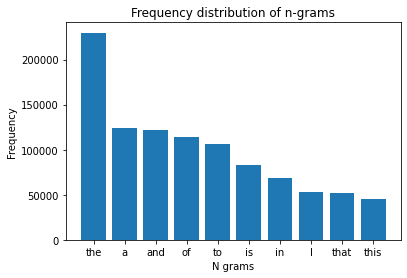

In [17]:
x, height = [key for key, val in vocab_sorted[:10]],[val for key, val in vocab_sorted[:10]]
plt.bar(x, height);
plt.xlabel('N grams')
plt.ylabel('Frequency')
plt.title('Frequency distribution of n-grams');

Distribution of sample length:

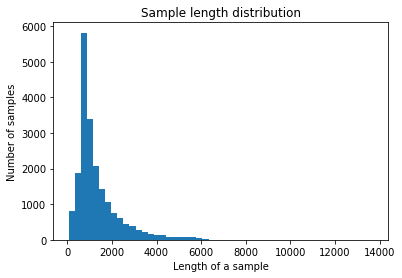

In [18]:
plt.hist([len(sample) for sample in train_data],bins=50);
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution');

## Choose a model
<img src='https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png'>

The ratio of “number of samples” (S) to “number of words per sample” (W) correlates with which model performs well.

In [19]:
ratio = number_of_samples / median_words_per_sample
print('The ratio of “number of samples” (S) to “number of words per sample” (W) is', ratio)

The ratio of “number of samples” (S) to “number of words per sample” (W) is 114.94252873563218



 
When the value for this ratio is small (less than 1500) use a sequence model small multi-layer perceptrons that take n-grams as input perform better or at least as well as sequence models. 
 
MLPs are simple to define and understand, and they take much less compute time than sequence models.

When the value for this ratio is large (>= 1500), use a sequence model

## Prepare your Data

### N-grams

* Tokenize text samples into word `uni+bigrams`,
* Vectorize using `tf-idf` encoding,
* Select only the top 20,000 features from the vector of tokens by discarding
 tokens that appear fewer than 2 times and using `f_classif` to calculate feature importance.

#### Method 1 using Tensorflow `tf.keras.layers.TextVectorization`
`tf.keras.layers.experimental.preprocessing.TextVectorization`

In [20]:
# method 1 using 'tf.keras.layers.experimental.preprocessing.TextVectorization'

tf_n_grams = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=20000,
                                                                          ngrams=(1, 2),
                                                                          output_mode='tf_idf',
                                                                          pad_to_max_tokens=True)

# create a text only dataset and call adapt on it
text_ds = raw_train_ds.map(lambda text,label:text)
# learn the vocabulary
tf_n_grams.adapt(text_ds)

In [21]:
# utility that standardize, tokenize and vectorize
def tf_vectorize_n_grams(text, label):
  text = tf.expand_dims(text, -1)
  return tf_n_grams(text), label

In [22]:
# standardize, tokenize and vectorize the dataset
n_grams_train_ds = raw_train_ds.map(tf_vectorize_n_grams)
n_grams_val_ds = raw_val_ds.map(tf_vectorize_n_grams)
n_grams_test_ds = raw_test_ds.map(tf_vectorize_n_grams)

#### Method 2 using Sklearn `sklearn.feature_extraction.text.TfidfVectorizer`

In [23]:
def sklearn_vectorize_n_grams(train_data, train_labels, val_data, test_data):
  # initialize TfidfVectorizer
  tf_idf = TfidfVectorizer(decode_error='replace',
                           strip_accents='unicode',
                           analyzer='word',
                           ngram_range=(1, 2),
                           min_df=2,
                           )
  # Learn vocabulary from training texts and vectorize training texts.                         
  train_text = tf_idf.fit_transform(train_data)
  # vectorize validation and test texts.
  val_text = tf_idf.transform(val_data)
  test_text = tf_idf.transform(test_data)


  # Select top 'k' of the vectorized features.
  top_k = SelectKBest(f_classif, k=min(20000, train_text.shape[1]))
  train_text = top_k.fit_transform(train_text, train_labels)
  val_text = top_k.transform(val_text)
  test_text = top_k.transform(test_text)

  return train_text, val_text, test_text

In [24]:
# Convert a collection of raw documents to a matrix of TF-IDF features.
n_grams_train_data, n_grams_val_data, n_grams_test_data = sklearn_vectorize_n_grams(train_data, train_labels, val_data, test_data)

With n-gram vector representation, we discard a lot of information about word order and grammar (at best, we can maintain some partial ordering information when n > 1).

This is called a bag-of-words approach. This representation is used in conjunction with models that don’t take ordering into account, such as logistic regression, multi-layer perceptrons, gradient boosting machines, support vector machines.

### Sequence Vector

For some text samples, word order is critical to the text’s meaning. For example, the sentences, “I used to hate my commute. My new bike changed that completely” can be understood only when read in order. Models such as CNNs/RNNs can infer meaning from the order of words in a sample. For these models, we represent the text as a sequence of tokens, preserving order.

**Tokenization**<br>
Text can be represented as either a sequence of characters, or a sequence of words. We have found that using word-level representation provides better performance than character tokens. This is also the general norm that is followed by industry. Using character tokens makes sense only if texts have lots of typos, which isn’t normally the case.

**Vectorization**<br>
Once we have converted our text samples into sequences of words, we need to turn these sequences into numerical vectors.There are two options available to vectorize the token sequences:
* One Hot Encoding<br>
Sequences are represented using word vectors in n- dimensional space where n = size of vocabulary. This representation works great when we are tokenizing as characters, and the vocabulary is therefore small. When we are tokenizing as words, the vocabulary will usually have tens of thousands of tokens, making the one-hot vectors very sparse and inefficient.
* Word Embedding<br>
Words have meaning(s) associated with them. As a result, we can represent word tokens in a dense vector space (~few hundred real numbers), where the location and distance between words indicates how similar they are semantically

Sequence models often have such an embedding layer as their first layer. This layer learns to turn word index sequences into word embedding vectors during the training process, such that each word index gets mapped to a dense vector of real values representing that word’s location in semantic space

Not all words in our data contribute to label predictions. We can optimize our learning process by discarding rare or irrelevant words from our vocabulary. In fact, we observe that using the most frequent 20,000 features is generally sufficient. This holds true for n-gram models as well 

steps:<br>
* Tokenizes the texts into words
* Creates a vocabulary using the top 20,000 tokens
* Converts the tokens into sequence vectors
* Pads the sequences to a fixed sequence length

#### Method 1 using `tf.keras.layers.TextVectorization`

In [25]:
tf_text_vectorize = tf.keras.layers.TextVectorization(max_tokens=20000,
                                                               output_mode='int',
                                                               output_sequence_length=500)

In [26]:
# create a text only dataset and call adapt
text_ds = raw_train_ds.map(lambda text,label:text)

# learn the vocab
tf_text_vectorize.adapt(text_ds)

In [27]:
# utitliy fn for standardize , tokenize , vectorize
def tf_vectorize_text_to_sequence(text, label):
  text = tf.expand_dims(text, -1)
  return tf_text_vectorize(text), label

In [28]:
# standardize, tokenize and vectorize the dataset
sequence_train_ds = raw_train_ds.map(tf_vectorize_text_to_sequence, num_parallel_calls=tf.data.AUTOTUNE)
sequence_val_ds = raw_val_ds.map(tf_vectorize_text_to_sequence, num_parallel_calls=tf.data.AUTOTUNE)
sequence_test_ds = raw_test_ds.map(tf_vectorize_text_to_sequence, num_parallel_calls=tf.data.AUTOTUNE)

#### Method 2 using `tf.keras.preprocessing`

`text_to_word_sequence(...)`: Converts a text to a sequence of words (or tokens).

`pad_sequences(...)`: Pads sequences to the same length.



In [29]:
def tf_preprocess_text(train_data, val_data, test_data):
  # initialize a tokenizer
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
  # learn the vocab
  tokenizer.fit_on_texts(train_data)
  # Vectorize training, validation and testing texts.
  train_text = tokenizer.texts_to_sequences(train_data)
  val_text = tokenizer.texts_to_sequences(val_data)
  test_text = tokenizer.texts_to_sequences(test_data)
  # get max length
  max_len = len(max(train_text, key=len))
  if max_len > 500:
    max_len = 500
  
  # Fix sequence length to max value. Sequences shorter than the length are
  # padded in the beginning and sequences longer are truncated
  # at the beginning.
  train_text = tf.keras.preprocessing.sequence.pad_sequences(train_text, maxlen=max_len)
  val_text = tf.keras.preprocessing.sequence.pad_sequences(val_text, maxlen=max_len)
  test_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, maxlen=max_len)

  return train_text, val_text, test_text

In [30]:
# preprocessing text to convert into sequence of word indices
sequence_train_data, sequence_val_data, sequence_test_data = tf_preprocess_text(train_data, val_data, test_data)

## Build, Train, and Evaluate Your Model

The input layer and the intermediate layers will be constructed differently, depending on whether we’re building an n-gram or a sequence model. But irrespective of model type, the last layer will be the same for a given problem.

<img src='https://developers.google.com/machine-learning/guides/text-classification/images/LastLayer.png'>

In [31]:
def get_last_layer_units_and_activation(num_class):
  if num_class == 2:
    units = 1
    activation = 'sigmoid'
  else:
    units = num_class 
    activation = 'softmax'
  
  return units, activation

When the S/W ratio is small, we’ve found that n-gram models perform better than sequence models. Sequence models are better when there are a large number of small, dense vectors. This is because embedding relationships are learned in dense space, and this happens best over many samples.

### N-gram Model

In [32]:
def mlp(units, activation, layers, dropout_rate, num_class, input_shape):
  # last-layer units & activation
  op_units, op_activation = get_last_layer_units_and_activation(num_class)
  # sequential model
  model = tf.keras.Sequential()
  # model.add(tf.keras.layers.Dropout(rate=dropout_rate, input_shape=input_shape))
  for layer in range(layers-1):
    model.add(tf.keras.layers.Dense(units=units, activation=activation, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
  # last-layer
  model.add(tf.keras.layers.Dense(op_units))
  return model

In [33]:
# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

#### MLP model using data preprocessed with TF TextVectorization (Method 1)

In [34]:
# create an instance of MLP model
mlp_model_1 = mlp(units=32,
                activation='relu',
                layers=2,
                dropout_rate=0.5,
                num_class=number_of_classes,
                input_shape=n_grams_train_data.shape[1:])

In [35]:
mlp_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                640032    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 640,065
Trainable params: 640,065
Non-trainable params: 0
_________________________________________________________________


In [36]:
# compile the model
mlp_model_1.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [37]:
# training
mlp_model_1_history = mlp_model_1.fit(n_grams_train_ds,
                                      epochs=5,
                                      callbacks=[early_stopping],
                                      validation_data=n_grams_val_ds )

Epoch 1/5
625/625 [==============================] - 14s 21ms/step - loss: 0.4512 - accuracy: 0.7828 - val_loss: 0.3033 - val_accuracy: 0.8428
Epoch 2/5
625/625 [==============================] - 13s 20ms/step - loss: 0.2395 - accuracy: 0.8907 - val_loss: 0.2537 - val_accuracy: 0.8998
Epoch 3/5
625/625 [==============================] - 13s 20ms/step - loss: 0.1820 - accuracy: 0.9144 - val_loss: 0.2803 - val_accuracy: 0.8952


In [38]:
loss, accuracy = mlp_model_1.evaluate(n_grams_test_ds)
print('Loss is ',loss)
print('Accuracy is',accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.2984 - accuracy: 0.8842
Loss is  0.29843515157699585
Accuracy is 0.8841999769210815


#### MLP model using data preprocessed with Sklearn (method 2)

In [64]:
# create an instance of MLP model
mlp_model = mlp(units=32,
                activation='relu',
                layers=2,
                dropout_rate=0.5,
                num_class=number_of_classes,
                input_shape=n_grams_train_data.shape[1:])

In [65]:
# model summary
mlp_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 640,065
Trainable params: 640,065
Non-trainable params: 0
_________________________________________________________________


In [66]:
# compile the model
mlp_model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [67]:
# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

By convention, indices should be sorted in row-major order (or equivalently lexicographic order on the tuples indices[i]). This is not enforced when SparseTensor objects are constructed, but most ops assume correct ordering. If the ordering of sparse tensor st is wrong, a fixed version can be obtained by calling `tf.sparse.reorder(st)`. or `scipy.sparse.csr_matrix.sort_indices`

`csr_matrix.sort_indices()`
Sort the indices of this matrix in place

In [43]:
# First you convert the matrix to COO format.
#  Then you extract the indices, values, and shape and pass those directly to the SparseTensor constructor.
def convert_sparse_matrix_to_tf_sparse(sparse):
  coo = sparse.tocoo()
  indices = np.mat([coo.row, coo.col]).transpose()
  return tf.sparse.reorder(tf.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape))

n_grams_train_data_tf = convert_sparse_matrix_to_tf_sparse(n_grams_train_data)
n_grams_val_data_tf = convert_sparse_matrix_to_tf_sparse(n_grams_val_data)
n_grams_test_data_tf = convert_sparse_matrix_to_tf_sparse(n_grams_test_data)

In [68]:
# train the mlp
mlp_history = mlp_model.fit(x=n_grams_train_data_tf,
              y=train_labels,
              batch_size=128,
              epochs=5,
              callbacks=[early_stopping],
              validation_data=(n_grams_val_data_tf, val_labels) 
              )

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_6/dense_12/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_6/dense_12/embedding_lookup_sparse/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_6/dense_12/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


157/157 [==============================] - 4s 20ms/step - loss: 0.5750 - accuracy: 0.6138 - val_loss: 0.4451 - val_accuracy: 0.8156
Epoch 2/5
157/157 [==============================] - 3s 17ms/step - loss: 0.3483 - accuracy: 0.8694 - val_loss: 0.3127 - val_accuracy: 0.8724
Epoch 3/5
157/157 [==============================] - 3s 19ms/step - loss: 0.2466 - accuracy: 0.9117 - val_loss: 0.2652 - val_accuracy: 0.8904
Epoch 4/5
157/157 [==============================] - 3s 18ms/step - loss: 0.1948 - accuracy: 0.9316 - val_loss: 0.2434 - val_accuracy: 0.8966
Epoch 5/5
157/157 [==============================] - 3s 17ms/step - loss: 0.1624 - accuracy: 0.9448 - val_loss: 0.2329 - val_accuracy: 0.9014


In [69]:
loss, accuracy = mlp_model.evaluate(n_grams_test_data_tf, test_labels)
print('Loss is ',loss)
print('Accuracy is',accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.2400 - accuracy: 0.8940
Loss is  0.23997484147548676
Accuracy is 0.8939599990844727


### Sequence Model
Models that can learn from the adjacency of tokens as sequence models. This includes CNN and RNN classes of models. Data is pre-processed as sequence vectors for these models. 

sepCNNs, a convolutional network variant that is often more data-efficient and compute-efficient, perform better than the other models.

Sequence models generally have a larger number of parameters to learn. The first layer in these models is an embedding layer, which learns the relationship between the words in a dense vector space. Learning word relationships works best over many samples.

Words in a given dataset are most likely not unique to that dataset. We can thus learn the relationship between the words in our dataset using other dataset(s). To do so, we can transfer an embedding learned from another dataset into our embedding layer. These embeddings are referred to as pre-trained embeddings. 

Fine-tuned embeddings yield better accuracy. However, this comes at the expense of increased compute power required to train the network. Given a sufficient number of samples, we could do just as well learning an embedding from scratch. We observed that for S/W > 15K, starting from scratch effectively yields about the same accuracy as using fine-tuned embedding.

#### Model using pre-trained embedding
Using a pre-trained embedding gives the model a head start in the learning process.

* nnlm-en-dim50
* Token based text embedding trained on English Google News 7B corpus.

* The module takes a batch of sentences in a 1-D tensor of strings as input.
* The module preprocesses its input by splitting on spaces.
* Note that no matter the length of the input text,
* the output shape of the embeddings is: (num_examples, embedding_dimension).

In [70]:
# nnlm-en-dim50
# Token based text embedding trained on English Google News 7B corpus.
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
# The module takes a batch of sentences in a 1-D tensor of strings as input.
# The module preprocesses its input by splitting on spaces.
# Note that no matter the length of the input text,
# the output shape of the embeddings is: (num_examples, embedding_dimension).

Pre-trained embedding -- we froze the weights of pre-trained embedding 

In [79]:
hub_layer = hub.KerasLayer(handle=embedding, trainable=False, dtype=tf.string)

A simple model that uses pretrained embedding 

In [80]:
inputs = tf.keras.Input(shape=[],dtype=tf.string)
# embedding layer
x = hub_layer(inputs, training=False)
# drop out layer
x = tf.keras.layers.Dropout(0.2)(x)
# dense layer
x = tf.keras.layers.Dense(units=32, activation='relu')(x)
# drop out layer
x = tf.keras.layers.Dropout(0.2)(x)
# classifier
outputs = tf.keras.layers.Dense(units=1)(x)
# Model using pre-trained embedding
pre_trained_embedding_model = tf.keras.Model(inputs, outputs)

In [81]:
# compile the model
pre_trained_embedding_model.compile(optimizer='adam',
                                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                                    metrics=['accuracy'])

In [82]:
# model summary
pre_trained_embedding_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 48,192,265
Trainable params: 1,665
Non-trainable params: 48,190,600
___________________________________________

In [83]:
# training the model

pre_trained_embedding_model.fit(x=train_data,
                                y=train_labels.tolist(),
                                batch_size=32,
                                epochs=10,
                                validation_data=(val_data, val_labels.tolist()),
                                callbacks=[early_stopping])

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6331 - accuracy: 0.6016 - val_loss: 0.5682 - val_accuracy: 0.6650
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5998 - accuracy: 0.6560 - val_loss: 0.5563 - val_accuracy: 0.6782
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5933 - accuracy: 0.6619 - val_loss: 0.5543 - val_accuracy: 0.6770
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5940 - accuracy: 0.6567 - val_loss: 0.5558 - val_accuracy: 0.7004


if we froze the weights of the pre-trained embeddings and trained just the rest of the network, the models did not perform well. 

This could be because the context in which the embedding layer was trained might have been different from the context in which we were using it.


In [84]:
loss, accuracy = pre_trained_embedding_model.evaluate(test_data, test_labels.tolist())
print('Loss ',loss)
print('Accuracy ',accuracy)

782/782 [==============================] - 3s 3ms/step - loss: 0.5625 - accuracy: 0.6890
Loss  0.5625265836715698
Accuracy  0.6890400052070618


The data embeddings trained on may not align with the language patterns in our IMDb dataset. The relationships inferred may need some updation  —i.e., the embedding weights may need contextual tuning. We do this in two stages:

* In the first run, with the embedding layer weights frozen, we allow the rest of the network to learn.

* In the second run, we allow the embedding layer to also learn, making fine adjustments to all weights in the network. We refer to this process as using a fine-tuned embedding.

In [85]:
# un-froze the weights of embedding layer
hub_layer.trainable = True

It's important to recompile your model after you make any changes to the `trainable` attribute of any inner layer, so that your changes are take into account

In [86]:
# recompile the model
pre_trained_embedding_model.compile(optimizer='adam',
                                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                                    metrics=['accuracy']) 

In [87]:
# train
pre_trained_embedding_model.fit(x=train_data,
                                y=train_labels.tolist(),
                                batch_size=32,
                                epochs=10,
                                validation_data=(val_data, val_labels.tolist()),
                                callbacks=[early_stopping])

Epoch 1/10
625/625 [==============================] - 302s 482ms/step - loss: 0.4066 - accuracy: 0.8033 - val_loss: 0.3060 - val_accuracy: 0.8690
Epoch 2/10
625/625 [==============================] - 319s 511ms/step - loss: 0.2106 - accuracy: 0.9153 - val_loss: 0.3230 - val_accuracy: 0.8726


In [88]:
loss, accuracy = pre_trained_embedding_model.evaluate(test_data, test_labels.tolist())
print('Loss ',loss)
print('Accuracy ',accuracy)

782/782 [==============================] - 42s 53ms/step - loss: 0.3376 - accuracy: 0.8697
Loss  0.3375718295574188
Accuracy  0.8697199821472168


Fine-tuned embeddings yield better accuracy. However, this comes at the expense of increased compute power required to train the network. Given a sufficient number of samples, we could do just as well learning an embedding from scratch. We observed that for S/W > 15K, starting from scratch effectively yields about the same accuracy as using fine-tuned embedding.

#### Model learning an embedding from scratch

In [108]:
def sequence_model(in_dim, out_dim, num_blocks, num_filters, kernel_size, pool_size, dropout_rate, num_class):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(input_dim=in_dim, output_dim=out_dim))

  for block in range(num_blocks-1):
    model.add(tf.keras.layers.SeparableConv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))

  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dropout(rate=dropout_rate))

  op_units, op_activation = get_last_layer_units_and_activation(num_class)
  model.add(tf.keras.layers.Dense(units=op_units))

  return model

In [109]:
# create an instance of sequence model
seq_model = sequence_model(in_dim=20000,
                           out_dim=16,
                           num_blocks=2,
                           num_filters=32,
                           kernel_size=3,
                           pool_size=3,
                           dropout_rate=0.2,
                           num_class=2)

In [110]:
# compile the model
seq_model.compile(optimizer='adam',
                 loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [113]:
# Train the model
# input to the model -- sequence of word indices  (Sequence vectors created using method 1 or method 2 ) here we are using data preprocessed by method-1
seq_model.fit(sequence_train_ds,
              epochs=10,
              validation_data=sequence_val_ds,
              callbacks=[early_stopping])

Epoch 1/10
625/625 [==============================] - 16s 25ms/step - loss: 0.6024 - accuracy: 0.5954 - val_loss: 0.3906 - val_accuracy: 0.8188
Epoch 2/10
625/625 [==============================] - 16s 25ms/step - loss: 0.3240 - accuracy: 0.8619 - val_loss: 0.2890 - val_accuracy: 0.8784
Epoch 3/10
625/625 [==============================] - 16s 25ms/step - loss: 0.2450 - accuracy: 0.9054 - val_loss: 0.2660 - val_accuracy: 0.8868
Epoch 4/10
625/625 [==============================] - 16s 25ms/step - loss: 0.1954 - accuracy: 0.9250 - val_loss: 0.2578 - val_accuracy: 0.8902
Epoch 5/10
625/625 [==============================] - 16s 26ms/step - loss: 0.1614 - accuracy: 0.9386 - val_loss: 0.2606 - val_accuracy: 0.8914


In [114]:
loss, accuracy = seq_model.evaluate(sequence_test_ds)
print('Loss ',loss)
print('Accuracy ',accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.2926 - accuracy: 0.8783
Loss  0.29260843992233276
Accuracy  0.8783199787139893
